# Segmantic Segmentation with VGG16

The initial attempt with using a GAN hit a wall, specifically with figuring out how to do proper layer sizing for the transposed convolution layers for the generator. On top of that, some research I did during my "off" time showed that the approach semantic segmentation using either an FCN (Fully Convolutional Network) approach or SegNet would work best.

Since SegNet is completely new, whereas transfer learning with VGG16 is something I'm familiar with, I'm going to attempt a VGG16 network here.

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
from glob import glob
import os
import os.path
import scipy
import math

%matplotlib inline

import tensorflow as tf
#Check GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('TensorFlow Version: {}'.format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow Version: 1.6.0


In [2]:
#useful variables
num_classes = 13 # none and 12 options, 0-12
image_shape = (160, 576)
# image_shape = (576, 160)
weights_initializer_stddev = 0.01
weights_regularized_l2 = 1e-3

## Load VGG16


First we're going to load VGG16 with pretrained weights (so it maintains its feature detectors, which can be useful for our smaller dataset).

In [3]:
#Download VGG16 if it is not already
from urllib.request import urlretrieve
import zipfile

if not os.path.exists("vgg16.zip"):
    urlretrieve(
        'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
        "./vgg16.zip")
    print("Downloaded VGG16 model weights")
else:
    print("Already exists, skipping download")

Already exists, skipping download


In [4]:
#Extract if needed
if not os.path.exists("./vgg"):
    unzip = zipfile.ZipFile("./vgg16.zip", "r")
    unzip.extractall("./")
    unzip.close()
    print("Extracted VGG16 model weights")
else:
    print("Already exists, skipping extraction")

Already exists, skipping extraction


### Helper Functions

First a couple of helper functions. Our output is an array of as any dimensions as we have classes - 13 by default, 3 for the given challenge.

The data comes in with all data on the red channel - 0-12 for the given class. I need to be able to return this format as well, so I have to convert from this image format to the multi-dimensional array - and vice versa.

In [5]:
#Make a map more colorful
def convertToColor(value):
    colors = [
        (255, 255, 255),   #0
        (255, 0, 0),      #1
        (0, 255, 0),      #2
        (0, 0, 255),      #3
        (255, 255, 0),    #4
        (127, 0, 255),    #5
        (51, 255, 51),    #6
        (255, 0, 127),    #7
        (127, 127, 127),  #8
        (0, 0, 0),        #9
        (0, 255, 255),  #10
        (0, 0, 100),      #11
        (100, 0, 0),      #12
    ]
    return colors[value[0]]

def colorizeMap(img):
    return [list( map(convertToColor, row) ) for row in img]

In [6]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    truths = [
        (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
    ]
    
    return truths[value[0]]

def truthToPixel(value):
    tmp = value.tolist()
    return (tmp.index(max(tmp)), 0, 0)

def imageToTruth(img):
    return [list(map(pixelToTruth, row)) for row in img]

def truthToImage(truth):
    return [list(map(truthToPixel, row)) for row in truth]

The below creates a batch iterator for us for training

In [7]:
# Function to load the image data and the label for it
def get_training_data(batch_size):
    #Both inputs and ground truth maps have the same name - easy!
    image_paths = glob(os.path.join("./data/Train/CameraRGB", "*.png"))
    label_paths = glob(os.path.join("./data/Train/CameraSeg", "*.png"))
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
        
        for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
            map_file = os.path.join(label_paths[index])
            
            image = scipy.misc.imread(image_file)
            image = scipy.misc.imresize(image, image_shape)
#             image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
            map_image = scipy.misc.imread(map_file)
            map_image = scipy.misc.imresize(map_image, image_shape)
            map_image = imageToTruth(map_image)
            
            images.append(image)
            maps.append(map_image)

        yield np.array(images), np.array(maps)
            
            

We're going to use the `model` object to keep track of each layer of our deep net for easy reference and debugging.

In [8]:
#Deep learning model
model = {}

Generate placeholders

In [9]:
def get_placeholders(model):
    model['placeholders'] = {}
    
    #Placeholders
    model['placeholders']['label'] = tf.placeholder(tf.int32, (None, image_shape[0], image_shape[1], model['settings']['num_classes']), name='label')
    model['placeholders']['learning_rate'] = tf.placeholder(tf.float32, name='learning_rate')

Load the VGG and pull out key aspects (keep_prob) andlayers (input, layers 3, 4, and 7)

In [10]:
def load_vgg(model):
    #Grab layers from pretrained VGG
    tf.saved_model.loader.load(sess, ["vgg16"], "./vgg/")
    
    model['graph'] = tf.get_default_graph()
    
    #define key layers for us to work with, so we can take pieces of VGG16
    #for our own use
    model['input_layer'] = model['graph'].get_tensor_by_name("image_input:0")
    model['keep_prob'] = model['graph'].get_tensor_by_name("keep_prob:0") #Dropout settings
    
    #more layer grabbing
    model['layer_3'] = model['graph'].get_tensor_by_name("layer3_out:0")
    model['layer_4'] = model['graph'].get_tensor_by_name("layer4_out:0")
    model['layer_7'] = model['graph'].get_tensor_by_name("layer7_out:0")

Build the FCN off of the VGG

In [11]:
def vgg_fcn(model):
    # Skip connections for later
    model['skip_conv_3'] = tf.layers.conv2d(model['layer_3'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            name='skip_conv_3')
    
    model['skip_conv_4'] = tf.layers.conv2d(model['layer_4'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            name='skip_conv_4')
    
    #Layer 7 isn't skipped, it's passed right to transpose    
    model['fully_connected_convs'] = tf.layers.conv2d(model['layer_7'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            name='fully_connected_convs')
    
    #From layer 7 we need to transpose up
    model['transpose_1'] = tf.layers.conv2d_transpose(model['fully_connected_convs'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            name='transpose_1')
    
    # Add the skip layer from layer 4
    model['skip_1'] = tf.add(model['transpose_1'], model['skip_conv_4'], name='skip_1')
    
    #Tranpose up from resultant layer
    model['transpose_2'] = tf.layers.conv2d_transpose(model['skip_1'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            name='transpose_2')
    
    #Create skip layer from layer 3
    model['skip_2'] = tf.add(model['skip_conv_3'], model['transpose_2'], name='skip_2')
    
    #Final output layer
    model['output_layer'] = tf.layers.conv2d_transpose(model['skip_2'], model['settings']['num_classes'], 16, 8, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            activation=tf.sigmoid, name='output_layer')
    
    return model['output_layer']

Generate logits

In [12]:
def get_logits(model):
    model['logits'] = {}
    
    #Create the optimzer
    model['logits']['logits'] = tf.reshape(model['output_layer'], (-1, model['settings']['num_classes']))
    model['logits']['correct_label'] = tf.reshape(model['placeholders']['label'], (-1, model['settings']['num_classes']))

Create loss functions and training operation

In [13]:
def get_loss(model):
    model['loss'] = {}
    
    model['loss']['softmax'] = tf.nn.softmax_cross_entropy_with_logits_v2(logits=model['logits']['logits'], labels=model['logits']['correct_label'])
    model['loss']['cross_entropy_loss'] = tf.reduce_mean(model['loss']['softmax'])
    model['loss']['optimizer'] = tf.train.AdamOptimizer(learning_rate=model['placeholders']['learning_rate'])
    model['loss']['train_op'] = model['loss']['optimizer'].minimize(model['loss']['cross_entropy_loss'])

Model traning function

In [14]:
def train(sess, model, epochs=1, batch_size=10, keep_probability=0.5, learning_rate_alpha=0.001):
    
    sess.run(tf.global_variables_initializer())
    
    print("Graph has been built - launching training")
    print("====== :-) ======")
    print()
    
    for epoch in range(epochs):
        print("Launching Epoch {}".format(epoch))
        loss_log = []
        batch_count = 0
        
        #get the images
        for image, truth in get_training_data(batch_size):
            batch_count += 1
            _, loss = sess.run(
                    [model['loss']['train_op'], model['loss']['cross_entropy_loss']],
                    feed_dict = {
                        model['input_layer']: image,
                        model['placeholders']['label']: truth,
                        model['keep_prob']: keep_probability,
                        model['placeholders']['learning_rate']: learning_rate_alpha
                    }
                )
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % 10 == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}/fcn_model".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
    print("Training finished")

Combine the above functions for building our net and use them below to run the net and train it.

Note that as of this run, we're using 13 classes, whereas our actual network uses 3. This is really just to see if it trains decently well and what our output is like. I'll only run 10 epochs. and see what I can get

In [ ]:
saver = None

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 10, 10, 0.75, 0.0001)
  

After training above, we don't have great results, but let's see what the network is doing.

I didn't expect great results - given the very tiny size of the dataset and the number of classes we have to define, I'd expect poor results. This is mostly to ensure we don't have any oddities in training and the network architecture *can* learn, and that our output looks even somewhat "correct".

In [15]:
def execute_on_image(sess, model):

    chosen_image = "165"
    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure()
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    plt.figure()
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure()
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
    return output

In [15]:
saver = None

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_9/fcn_model')
    
    results = execute_on_image(sess, model)

Not too bad for such a high loss - it mostly gets the car hood and the road - definitely didn't get the buildings or the fence posts.

I saved the model used for above as `13_classes_model.zip`

## Moving over to just 3 classes

With the dataset at the size it is, this network would never reach the level of clarity needed for all 13 classes. I'm going to now change some of the helper functions to convert data into a 3 class system - `roads`, `vehicles`, and `none`. This should make the network quite a bit better as it has less to learn.

In [16]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    if value[0] == 7:
        return (0, 1, 0)
    elif value[0] == 10:
        return (0, 0, 1)
    else:
        return (1, 0, 0)

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 50, 10, 0.5, 0.0001)
  

Loss looks far better than before as I expected. Obviously we're purposely overfitting here - no sense in combatting overfitting on the first go-through (though with a dropout of `0.5` we're pretty good - but I'm not holding back any for generalized validation testing, or doing any data augmentation atm. Let's look at an example output just as before.

I'll have to modify the `execute_on_image` function in order to prepare it for the 3 class pictures and draw them correctly. Note that the truth images, since it's labeling their classes as different #'s (out of 13 still) - the colors will be different - we're looking for similar clustering.

In [18]:
def execute_on_image(sess, model, chosen_image):

    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    # We're going to convert the truth to an image and back -
    # inefficient, but it should shape it back to the 
    # 3 classes
#     truth = imageToTruth(truthToImage(truth))
    plt.figure(figsize=(20,15))
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure(figsize=(20,15))
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
#     plt.figure(figsize=(20,15))
#     overlayed = cv2.addWeighted(image, 1.0, colorizedOutput, 0.5, 0)
#     plt.imshow(overlayed)
    
    return output

As a note, the model for this is saved as `3_classes_model.zip`.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "165")

Initial thought - the hood is problematic, but makes sense - the dataset always marks that as a car, so any pipeline that would work with this data would have to remove it anyway. As for the cars- it's not as fine-tuned as before, but it worked out pretty well - it *did* detect those as cars. Let's try another.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "396")

Here the results are less good - it seems the network doesn't quite get the car on the left - could be data, could be network.

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "633")

After seeomg this, it seems that the network kind of just likes to identify cars as down range, and as a result it is often right. It's not generalizing super well as is. I also think the loss is reporting super low because it nails the hood, sky, and sides as nothing quite accuately - this buffs its score despite missing so much on vehicles. I'm going to try experimenting with a few hyperparameters and see what we can do from there.

I debated starting from the pretrained model used above, but abandoned that idea in fear that the network learned to activate the center of the image for cars and ignore the sides too much and I might not be able to teach it to generalize.

First, FCNs are apparently effected by image size used inside the network - this makes sense, since we lose detail as we shrink the image. This makes the network larger and slower, however, but it's worth exploring.

Above, we used an image size of `576x160`- originally I had grabbed this from a ratio calculator, but in review, I realize that this isn't correct - it should be a 4:3 aspect ratio, and it looks like I'm using a 16:10 ratio. I'm not quite sure *why* that occured, but its' definitely causing issues. So I'm going to just move forward using `256x256` - the square ratio fixes shape issues, and I needed to shrink it to keep network size manageable in order to increase batch size.

In [18]:
image_shape = (256,256)

Below is a quick experiment to see how large a batch size my GPU can take (GTX1080 w/ 8gb RAM). This is because instead of decaying the learning rate, increasing the batch size gets similar results with less training time per [this paper](https://arxiv.org/abs/1711.00489).

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 1, 12, 0.5, 0.01)
  

Results of the above test was that while we can occasionally do batches of up to 15, you're pushing the memory limits so sometimes it will just outright crash with an OOM error - I'll stop at batches of 12.

So I'll do batches of 1, 2, 4, 6, 8, 10, and 12.

Below is a quick modification to the `train` function to accomdate multiple calls without overwriting previous training attempts.

In [24]:
def train(sess, model, starting_epoch=0, epochs=1, batch_size=10, keep_probability=0.5, learning_rate_alpha=0.001):
    
    #There are 1000 data samples, so I want 10 prints per epoch - so however many 
    #batches fit in that 1000 rounded up to 10 per is what I want.
    print_every = math.ceil((1000 / batch_size) / 10)
    
    print()
    print("====== Beginning training ======".format(batch_size))
    print()
    print("Training at a learning rate of {}".format(learning_rate_alpha))
    print("Batch size is set to {}".format(batch_size))
    print("Printing loss for every {} batches".format(print_every))
    print()
    
    print("====== ====== ====== ======")
    print()
    
    for epoch in range(starting_epoch, starting_epoch + epochs):
        print("Launching Epoch {}".format(epoch))
        loss_log = []
        batch_count = 0
        
        #get the images
        for image, truth in get_training_data(batch_size):
            batch_count += 1
            _, loss = sess.run(
                    [model['loss']['train_op'], model['loss']['cross_entropy_loss']],
                    feed_dict = {
                        model['input_layer']: image,
                        model['placeholders']['label']: truth,
                        model['keep_prob']: keep_probability,
                        model['placeholders']['learning_rate']: learning_rate_alpha
                    }
                )
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % print_every == 0 or batch_count == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}/fcn_model".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
        
    print("Finished training for batch size of {}".format(batch_size))

In [ ]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 0, 10, 1, 0.5, 0.001)
    train(sess, model, 10, 10, 2, 0.5, 0.001)
    train(sess, model, 20, 10, 4, 0.5, 0.001)
    train(sess, model, 30, 10, 8, 0.5, 0.001)
    train(sess, model, 40, 10, 10, 0.5, 0.001)
    train(sess, model, 50, 10, 12, 0.5, 0.001)
  

This didn't work out as I presumed. Initially I set 10 epochs for each, but by the end of the second epoch of batch size 1 training the loss hard spiraled out of control already. I retried it with a smaller batch size but got similar results - you can't do batch size of 1 with anything more than a super tiny learning rate. I tried again below, just a few epochs.

In [22]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
 
    train(sess, model, 0, 1, 4, 0.75, 0.0001)
    train(sess, model, 1, 1, 8, 0.75, 0.0001)
    train(sess, model, 2, 1, 10, 0.75, 0.0001)
    train(sess, model, 3, 1, 12, 0.75, 0.0001)
  

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'

====== Beginning training ======

Training at a learning rate of 0.0001
Batch size is set to 4
Printing loss for every 25.0 batches

====== ====== ====== ======

Launching Epoch 0


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch 25 - loss of 0.8941105008125305
Batch 50 - loss of 0.7772316932678223
Batch 75 - loss of 0.7294977903366089
Batch 100 - loss of 0.6973959803581238
Batch 125 - loss of 0.6722773313522339
Batch 150 - loss of 0.6626666188240051
Batch 175 - loss of 0.6341269016265869
Batch 200 - loss of 0.6279413104057312
Batch 225 - loss of 0.6239320039749146
Batch 250 - loss of 0.6194126605987549
Training for epoch finished -  0.619413
Model saved as ./chkpts/model_epoch_0/fcn_model

Finished training for batch size of 4

====== Beginning training ======

Training at a learning rate of 0.0001
Batch size is set to 8
Printing loss for every 12.5 batches

====== ====== ====== ======

Launching Epoch 1
Batch 25 - loss of 0.617925226688385
Batch 50 - loss of 0.6157503128051758
Batch 75 - loss of 0.6142357587814331
Batch 100 - loss of 0.6139125823974609
Batch 125 - loss of 0.6119066476821899
Training for epoch finished -  0.611907
Model saved as ./chkpts/model_epoch_1/fcn_model

Finished training for bat

This worked better in terms of training speed!

*However*. it seems that irregardless of method of training, I tend to peak out at about `0.60`ish loss.

The loss is amplified by the fact that it gets the carhood and sky as `vehicle`/`none` respectively. This means that the loss reported simply isn't good enough.

I think I'm going to start processing the images more - let's start with cropping and re-adding the vehicle hood on images.

Here's some quick playground testing in order to determine cropping positioning, and making sure it's easy to go from a completed output back to a proper full size one for comparison

/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


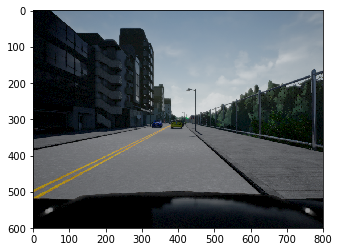

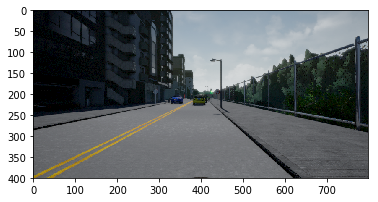

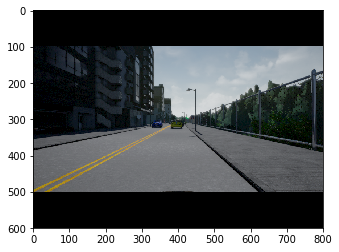

In [46]:
image = scipy.misc.imread("./data/Train/CameraRGB/165.png")
plt.figure()
plt.imshow(image)

image = image[100:500, 0:-1]
plt.figure()
plt.imshow(image)

bg = np.zeros((600,800,3), np.uint8)
bg[100:500, 0:-1] = image
plt.figure()
plt.imshow(bg)

In [49]:
# Function to load the image data and the label for it
def get_training_data(batch_size):
    #Both inputs and ground truth maps have the same name - easy!
    image_paths = glob(os.path.join("./data/Train/CameraRGB", "*.png"))
    label_paths = glob(os.path.join("./data/Train/CameraSeg", "*.png"))
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
        
        for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
            map_file = os.path.join(label_paths[index])
            
            image = scipy.misc.imread(image_file)
            image = image[100:500, 0:-1]
            image = scipy.misc.imresize(image, image_shape)
#             image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
            map_image = scipy.misc.imread(map_file)
            map_image = map_image[100:500, 0:-1]
            map_image = scipy.misc.imresize(map_image, image_shape)
            map_image = imageToTruth(map_image)
            
            images.append(image)
            maps.append(map_image)

        yield np.array(images), np.array(maps)
            
            

Now let's see if that improves training at all.

In [50]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
 
    train(sess, model, 0, 1, 4, 0.75, 0.0001)
    train(sess, model, 1, 2, 8, 0.75, 0.0001)
    train(sess, model, 3, 2, 10, 0.75, 0.0001)
    train(sess, model, 5, 3, 12, 0.75, 0.0001)

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'

====== Beginning training ======

Training at a learning rate of 0.0001
Batch size is set to 4
Printing loss for every 25 batches

====== ====== ====== ======

Launching Epoch 0


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch 25 - loss of 0.9025150537490845
Batch 50 - loss of 0.7992819547653198
Batch 75 - loss of 0.7455337643623352
Batch 100 - loss of 0.7387210130691528
Batch 125 - loss of 0.7260719537734985
Batch 150 - loss of 0.7131403684616089
Batch 175 - loss of 0.6907228827476501
Batch 200 - loss of 0.6803224086761475
Batch 225 - loss of 0.6760444641113281
Batch 250 - loss of 0.6711182594299316
Training for epoch finished -  0.671118
Model saved as ./chkpts/model_epoch_0/fcn_model

Finished training for batch size of 4

====== Beginning training ======

Training at a learning rate of 0.0001
Batch size is set to 8
Printing loss for every 13 batches

====== ====== ====== ======

Launching Epoch 1
Batch 13 - loss of 0.6690701246261597
Batch 26 - loss of 0.6636889576911926
Batch 39 - loss of 0.6547911167144775
Batch 52 - loss of 0.6490938067436218
Batch 65 - loss of 0.6469264030456543
Batch 78 - loss of 0.6436043977737427
Batch 91 - loss of 0.6397547125816345
Batch 104 - loss of 0.6415876150131226
Ba

In [51]:
def execute_on_image(sess, model, chosen_image):

    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = image[100:500, 0:-1]
    image = scipy.misc.imresize(image, image_shape)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = truth[100:500, 0:-1]
    truth = scipy.misc.imresize(truth, image_shape)
    
    # We're going to convert the truth to an image and back -
    # inefficient, but it should shape it back to the 
    # 3 classes
#     truth = imageToTruth(truthToImage(truth))
    plt.figure(figsize=(20,15))
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure(figsize=(20,15))
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
#     plt.figure(figsize=(20,15))
#     overlayed = cv2.addWeighted(image, 1.0, colorizedOutput, 0.5, 0)
#     plt.imshow(overlayed)
    
    return output

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "165")

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "337")

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_7/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_7/fcn_model')
    
    results = execute_on_image(sess, model, "395")

Bad results - about the same problem. I'll have to think of a better way to improve generalization or get more data.